**Описание проекта**

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.\
Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.\
В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

**Проверьте гипотезы**

Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

In [280]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

In [281]:
data = pd.read_csv('/datasets/games.csv')

In [282]:
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Итак в нашем распоряжении датафрейм сданными продажам игр в трех регионах и остальном мире, с указанием платформы, жанра, года выпуска, оценками критиков и игроков, рейтингом игры.

In [283]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


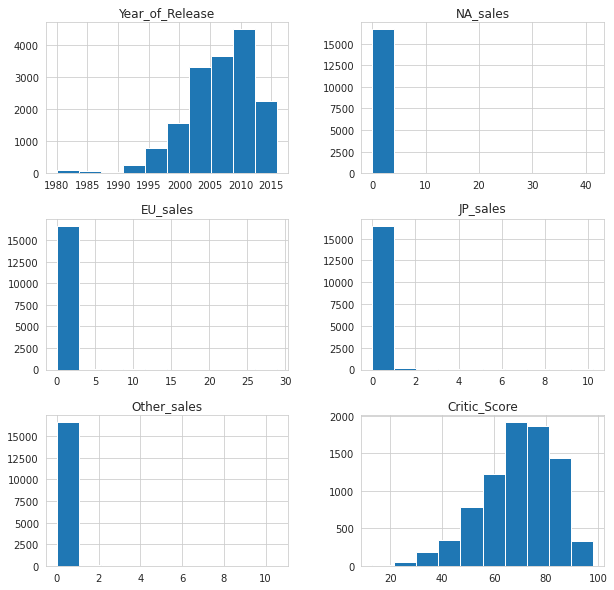

In [284]:
data.hist(figsize=(10,10));

В датафрейме есть пропуски, некоторые типы данных не соответствуют жиданиям, а также требуется коррекция названия столбцов. Так же для некоторых данных есть существенные выбросы, с которыми нужно работать.

**Приведу к нижнему регистру наименование столбцов**

In [285]:
data.columns = data.columns.str.lower()

**Оценим количество пропусков**

In [286]:
data.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

Пропуски в названии игры и году выхода удалим без сожаления. Их немного и их проблематично заполнить. Заодно год релиза переведу в тип datetime

In [287]:
data = data.dropna(subset=['year_of_release', 'name'])
data['year_of_release'] = pd.to_datetime(data['year_of_release'], format='%Y').dt.year
data.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8461
user_score         6605
rating             6676
dtype: int64

**Оценим что можно сделать с остальными пропусками.**

Оценки игроков

In [288]:
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

tbd - аббревиатура, по сути обозначающая "подлежит обсуждению". Без сожаления заменю на пустоту.\
Данный столбец нужен будет нам с типом данных float.\
Пустоту заменим на значение 1000 (так проще будет делать потом срез (или не проще, просто пришла такая мысль)).

In [289]:
data['user_score'] = data['user_score'].replace('tbd', np.NaN)
data['user_score'] = data['user_score'].astype(float)
data['user_score'] = data['user_score'].replace(np.NaN, 1000.0)

Оценки критиков

In [290]:
data['critic_score'].unique()

array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 41., 36., 31., 27., 35., 26., 19., 28., 23.,
       24., 21., 17., 13.])

Здесь стоит сделать тип данных int. С пропусками сделаю тоже самое.

In [291]:
data['critic_score'] = data['critic_score'].replace(np.NaN, 1000)
data['critic_score'] = data['critic_score'].astype(int)

Рейтинг.

In [292]:
data['rating'].unique()
data['rating'].value_counts()

E       3921
T       2905
M       1536
E10+    1393
EC         8
K-A        3
AO         1
RP         1
Name: rating, dtype: int64

Пустоту заменим на "неустановлен", а K-A на E (это одно и то же, просто E актуально)

In [293]:
data['rating'] = data['rating'].replace('K-A', 'E')
data['rating'] = data['rating'].replace(np.NaN, 'неустановлен')

In [294]:
data['rating'].unique()

array(['E', 'неустановлен', 'M', 'T', 'E10+', 'AO', 'EC', 'RP'],
      dtype=object)

<div class="alert alert-success">
<h2> Комментарий ревьюера V1<a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Остальные параметры обработал тоже верно.

In [295]:
data.isna().sum()

name               0
platform           0
year_of_release    0
genre              0
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
critic_score       0
user_score         0
rating             0
dtype: int64

Посмотрим наличие дубликатов.

In [296]:
data['genre'].unique()

array(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy'], dtype=object)

In [297]:
data['platform'].unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

In [298]:
data.duplicated(['name', 'genre', 'platform', 'year_of_release']).sum()

1

In [299]:
data = data.drop_duplicates(['name', 'genre', 'platform', 'year_of_release']) 

In [300]:
data.duplicated(['name', 'genre', 'platform', 'year_of_release']).sum()

0

In [301]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16443 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16443 non-null  object 
 1   platform         16443 non-null  object 
 2   year_of_release  16443 non-null  int64  
 3   genre            16443 non-null  object 
 4   na_sales         16443 non-null  float64
 5   eu_sales         16443 non-null  float64
 6   jp_sales         16443 non-null  float64
 7   other_sales      16443 non-null  float64
 8   critic_score     16443 non-null  int64  
 9   user_score       16443 non-null  float64
 10  rating           16443 non-null  object 
dtypes: float64(5), int64(2), object(4)
memory usage: 1.5+ MB


Создадим новый столбец с общими продажами по регионам

In [302]:
data['total_sales'] = data['jp_sales']+data['na_sales']+data['other_sales']+data['eu_sales']

**Провели оценку и обработку данных. Удалили данные которые дальше будут мешать. Поменяли типы данных, там где это уместо. Заменили некоторые данные для сохранения объема данных, там где это возможно.**

**Начнем анализ**

Посмотрим как менялось количество выпускаемых игр со временем.

In [303]:
data.groupby('year_of_release')['name'].count()

year_of_release
1980       9
1981      46
1982      36
1983      17
1984      14
1985      14
1986      21
1987      16
1988      15
1989      17
1990      16
1991      41
1992      43
1993      60
1994     121
1995     219
1996     263
1997     289
1998     379
1999     338
2000     350
2001     482
2002     829
2003     775
2004     762
2005     939
2006    1006
2007    1197
2008    1427
2009    1426
2010    1255
2011    1136
2012     652
2013     544
2014     581
2015     606
2016     502
Name: name, dtype: int64

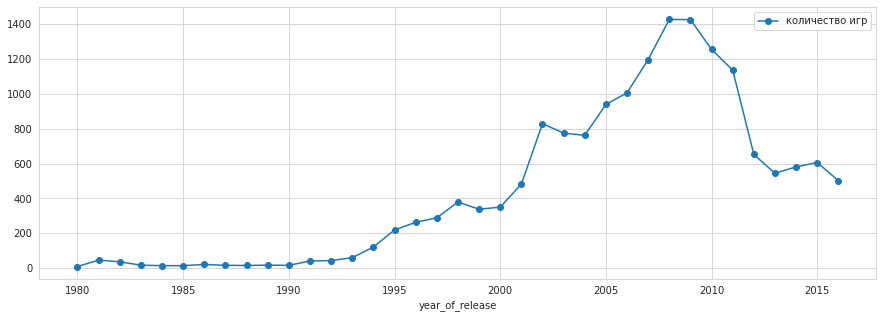

In [305]:
data.groupby('year_of_release')['name'].count().plot(style='o-', grid=True, figsize=(15, 5), label='количество игр');
plt.legend();

Интересно что максимум был в прошлом. Возможно это связано с уменьшение количества платформ. Остаются более прибыльные платформы, растут требования к разработчикам, уменьшается количество игр.\
Посмотрим что по платформам.

In [306]:
data.groupby('platform')['name'].count().sort_values(ascending=False)

platform
PS2     2127
DS      2121
PS3     1305
Wii     1286
X360    1232
PSP     1193
PS      1190
PC       957
GBA      811
XB       803
GC       542
3DS      512
PSV      429
PS4      392
N64      316
XOne     247
SNES     239
SAT      173
WiiU     147
2600     116
NES       98
GB        97
DC        52
GEN       27
NG        12
SCD        6
WS         6
3DO        3
TG16       2
PCFX       1
GG         1
Name: name, dtype: int64

In [307]:
dt = data.pivot_table(index='platform', values='total_sales', aggfunc='sum').sort_values(by='total_sales', ascending=False).reset_index().head(8)
dt

,platform,total_sales
0,PS2,1233.56
1,X360,961.24
2,PS3,931.33
3,Wii,891.18
4,DS,802.78
5,PS,727.58
6,PS4,314.14
7,GBA,312.88


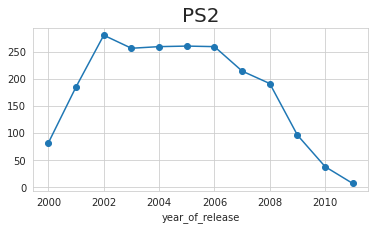

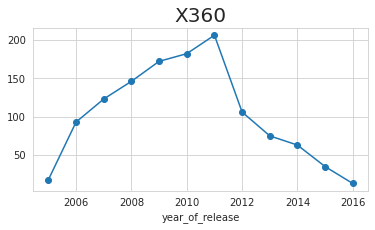

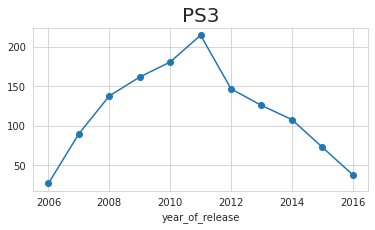

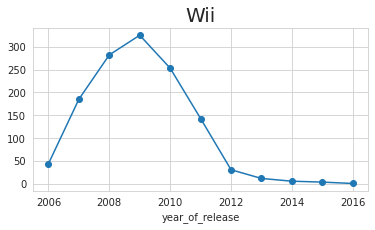

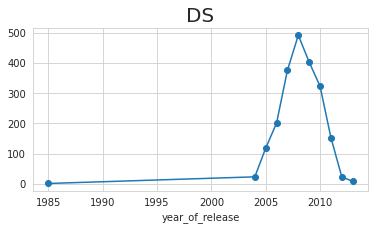

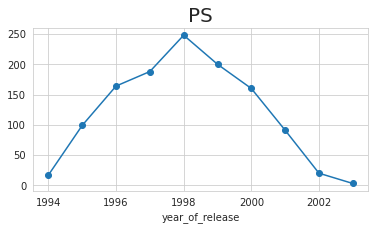

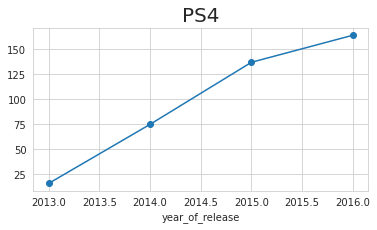

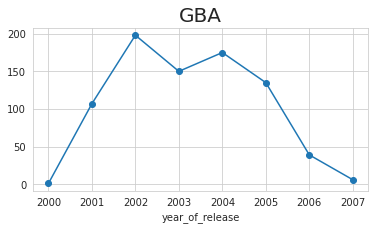

In [308]:
platform_name = dt['platform'].unique().tolist()
for a in platform_name:
  data.query('platform == @a').groupby('year_of_release')['name'].count().plot(style='o-', grid=True, figsize=(6, 3))
  plt.title(a, fontsize=20)
  plt.show()

Добавим еще два графика для XboxOne и PC. Без них игровая индустрия - не игровая индустрия)

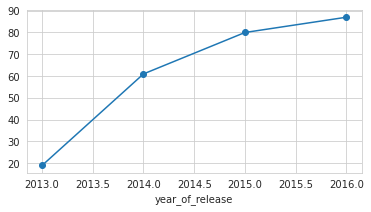

In [309]:
data.query('platform == "XOne"').\
groupby('year_of_release')['name'].count().plot(style='o-', grid=True, figsize=(6, 3));

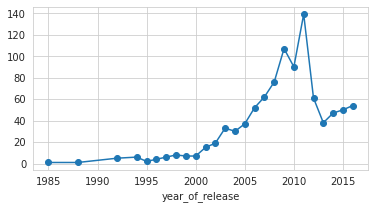

In [310]:
data.query('platform == "PC"').\
groupby('year_of_release')['name'].count().plot(style='o-', grid=True, figsize=(6, 3));

Ничего удивительного, более "свежие" платформы имеют тенденцию к росту количества игра, и наоборот.\
Вцелом платформы "живут" около 10 лет.\
И только пк-бояре на коне всегда =)


Для анализа перспектив на 2017 год возьмем последние 3 года. Игровая индустрия быстро меняется.

In [311]:
current_data = data.query('year_of_release > 2013')
current_data['platform'].unique()

array(['PS4', '3DS', 'XOne', 'WiiU', 'PS3', 'X360', 'PC', 'Wii', 'PSV',
       'PSP'], dtype=object)

In [312]:
current_data.groupby('platform')['name'].count().sort_values(ascending=False)

platform
PS4     376
PSV     295
XOne    228
PS3     219
3DS     212
PC      151
X360    111
WiiU     73
PSP      13
Wii      11
Name: name, dtype: int64

In [313]:
current_data.groupby('platform')['total_sales'].sum().sort_values(ascending=False)

platform
PS4     288.15
XOne    140.36
3DS      86.68
PS3      68.18
X360     48.22
WiiU     42.98
PC       27.05
PSV      22.40
Wii       5.07
PSP       0.36
Name: total_sales, dtype: float64

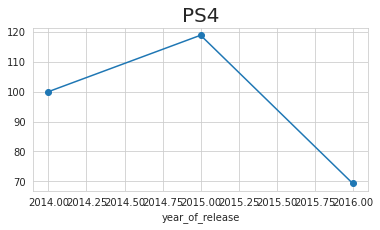

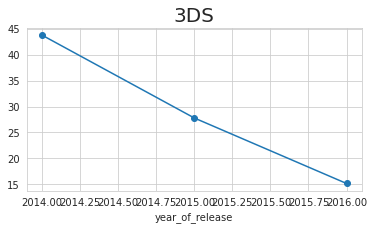

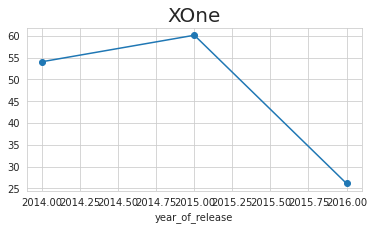

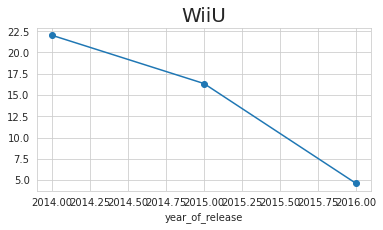

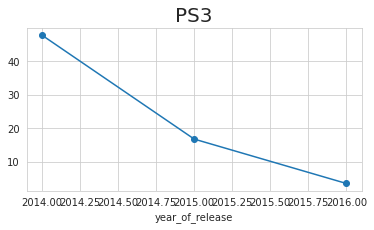

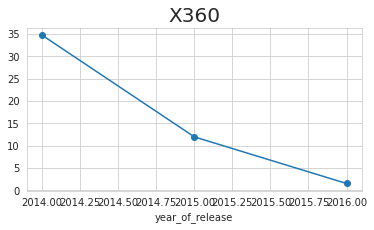

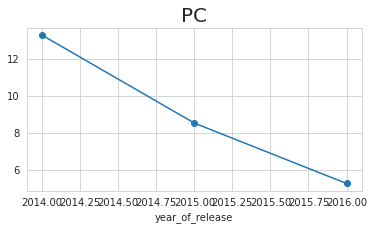

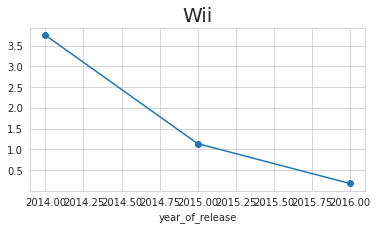

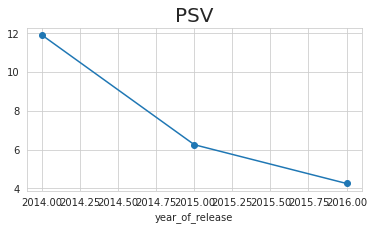

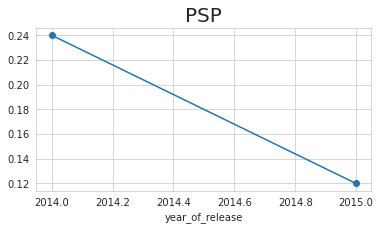

In [314]:
current_platform_name = current_data['platform'].unique().tolist()
for a in current_platform_name:
  current_data.query('platform == @a').groupby('year_of_release')['total_sales'].sum().plot(style='o-', grid=True, figsize=(6, 3))
  plt.title(a, fontsize=20)
  plt.show()

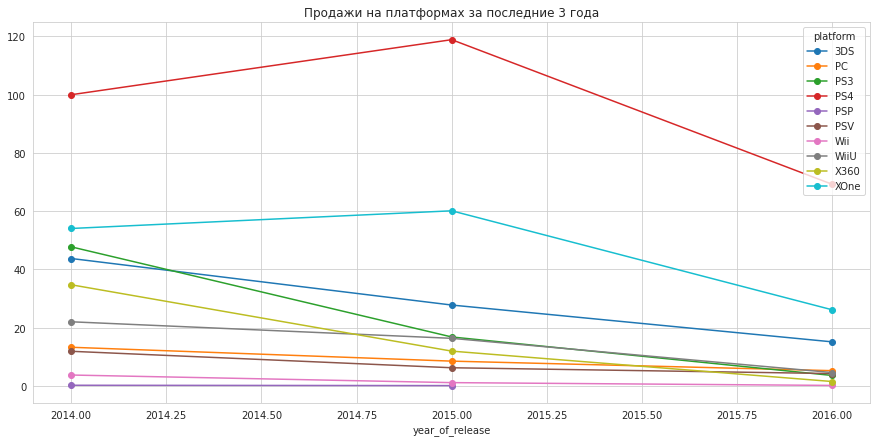

In [315]:
current_data.pivot_table(index='year_of_release', columns = 'platform', values='total_sales', aggfunc='sum')\
.plot(grid=True, figsize=(15, 7), style='o-')
plt.title('Продажи на платформах за последние 3 года')
plt.show()

Графики выглядят не очень наглядными. На сколько я понял 2016г еще не закончился, поэтому продажи должны еще вырасти. Можно сказать, что лидирует PS4. Имеет тенденцию к росту (если без 2016г) XboxOne и приличные значения продаж.

Всё же наиболее значимые платформы на тот момент - PS4, XboxOne, PC. Для них и построим "ящики с усами"

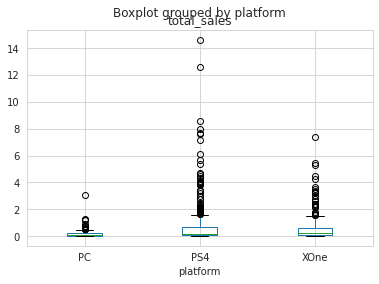

In [316]:
top_3 = ['PS4', 'XOne', 'PC']
current_data.query("platform == @top_3")\
.boxplot(column='total_sales', by='platform');

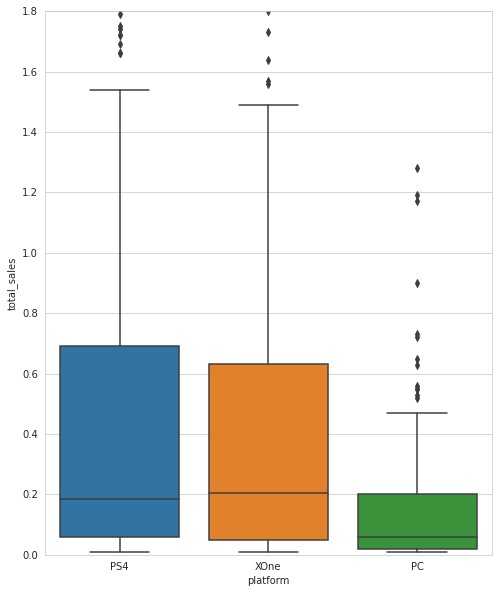

In [317]:
plt.figure(figsize=(8, 10))
plt.ylim(0, 1.8)
sns.boxplot(data=current_data.query("platform == @top_3"), x='platform', y='total_sales');

Интересно, что медиана продаж больше у XboxOne.\
Для построения графиков рассеения сделаем небольшое замечание.

In [318]:
print(current_data.shape[0])
current_data.query('critic_score != 1000 or user_score != 1000')['name'].count()\
 - current_data.query('critic_score != 1000 and user_score != 1000')['name'].count()

1689


198

**198 из 1689 строк содержат либо данные с оценкой критиков, либо с оценкой игроков. Что бы меньше сужать данные, буду брать срезы отдельно для оценок игроков и оценок критиков.**

Посмотрим корреляцию продаж и оценок критиков и игроков у PS4

Коэффициент корреляции: 0.402661410681041


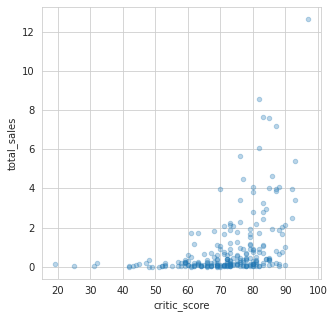

In [319]:
ps4_corr_crit = current_data.query('platform == "PS4" and critic_score != 1000')
ps4_corr_crit.plot(x='critic_score', y='total_sales', kind='scatter', alpha=0.3, figsize=(5,5), grid=True);
print('Коэффициент корреляции:', ps4_corr_crit['critic_score'].corr(ps4_corr_crit['total_sales']))

Корреляция не очень сильная, но явно присутствует.

Коэффициент корреляции: -0.04013158947269732


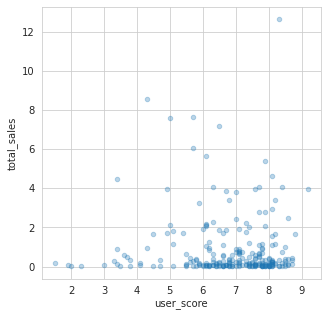

In [320]:
ps4_corr_user = current_data.query('platform == "PS4" and user_score != 1000')
ps4_corr_user.plot(x='user_score', y='total_sales', kind='scatter', alpha=0.3, figsize=(5,5), grid=True);
print('Коэффициент корреляции:', ps4_corr_user['user_score'].corr(ps4_corr_user['total_sales']))

Коэффициент близок к 0. Корреляции нет.

Теперь для PC и XboxOne

In [321]:
other_corr_user = current_data.query('user_score != 1000')
other_corr_crit = current_data.query('critic_score != 1000')

Коэффициент корреляции: 0.42867694370333226


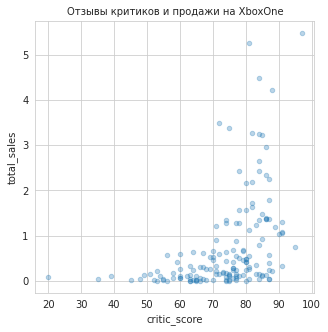

In [322]:
other_corr_crit.query('platform == "XOne"').\
plot(x='critic_score', y='total_sales', kind='scatter', alpha=0.3, figsize=(5,5), grid=True)
plt.title('Отзывы критиков и продажи на XboxOne', fontsize=10);
print('Коэффициент корреляции:', other_corr_crit.query('platform == "XOne"')['critic_score']\
      .corr(other_corr_crit.query('platform == "XOne"')['total_sales']))

Коэффициент корреляции: 0.1746341376935004


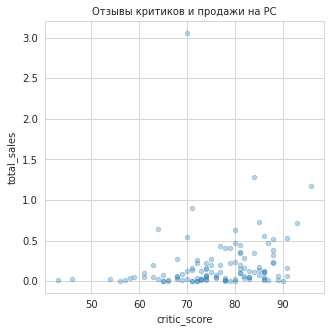

In [323]:
other_corr_crit.query('platform == "PC"')\
.plot(x='critic_score', y='total_sales', kind='scatter', alpha=0.3, figsize=(5,5), grid=True)
plt.title('Отзывы критиков и продажи на PC', fontsize=10);
print('Коэффициент корреляции:', other_corr_crit.query('platform == "PC"')['critic_score'].\
      corr(other_corr_crit.query('platform == "PC"')['total_sales']))

Коэффициент корреляции: -0.07038392806475807


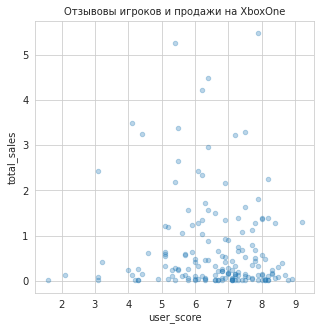

In [324]:
other_corr_user.query('platform == "XOne"')\
.plot(x='user_score', y='total_sales', kind='scatter', alpha=0.3, figsize=(5,5), grid=True)
plt.title('Отзывовы игроков и продажи на XboxOne', fontsize=10);
print('Коэффициент корреляции:', other_corr_user.query('platform == "XOne"')['user_score']\
      .corr(other_corr_user.query('platform == "XOne"')['total_sales']))

Коэффициент корреляции: -0.07159665703472451


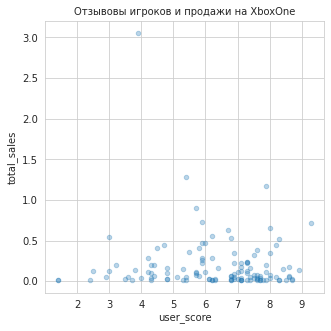

In [325]:
other_corr_user.query('platform == "PC"')\
.plot(x='user_score', y='total_sales', kind='scatter', alpha=0.3, figsize=(5,5), grid=True)
plt.title('Отзывовы игроков и продажи на XboxOne', fontsize=10);
print('Коэффициент корреляции:', other_corr_user.query('platform == "PC"')['user_score']\
      .corr(other_corr_user.query('platform == "PC"')['total_sales']))

Можно отметить что ни для одной платформы нет корреляции между продажами и оценками игроков

Корреляция у выбранных платформ и оценками критиков положительная. Она схожая у Xbox и PS - больше 0,4, что уже указывает на определенную зависимоть, но слабую. Для PC же она совсем небольшая 0,17. Таким образом, оценки критиков можно учитывать как дополнительный фактор не определяющий.

Посмотрим на распределение продаж по жанрам.

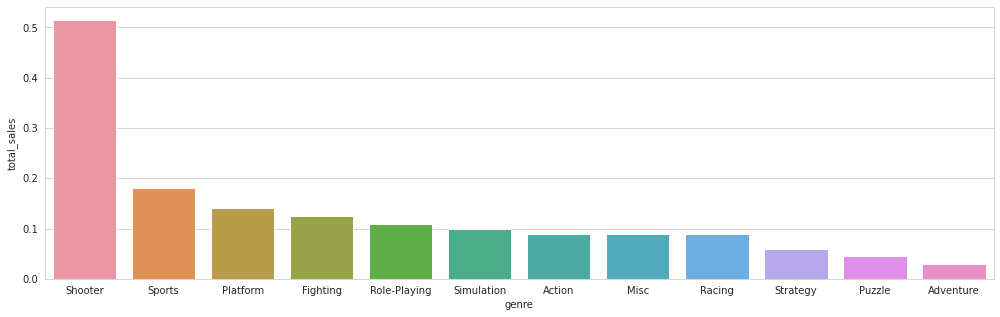

In [326]:
genre_sales = current_data.pivot_table(index='genre', values='total_sales', aggfunc='median')\
.sort_values(by='total_sales', ascending=False).reset_index()
plt.figure(figsize=(17, 5))
sns.barplot(x='genre', y='total_sales', data=genre_sales);

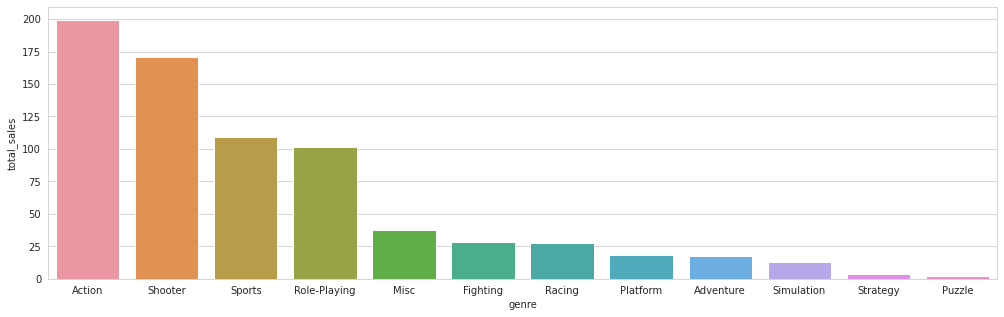

In [327]:
genre_sales = current_data.pivot_table(index='genre', values='total_sales', aggfunc='sum')\
.sort_values(by='total_sales', ascending=False).reset_index()
plt.figure(figsize=(17, 5))
sns.barplot(x='genre', y='total_sales', data=genre_sales);

Шутеры явно выделяются с сильным отрывом. Совсем все печально у пазлов(это просто нет мобильного гейминга) и приключений.

**На данном этапе можно сказать, что всреднем люди предпочитают PS4 и XboxOne и играть на них в шутеры.**

**Посмотрим на региональные предпочтения**

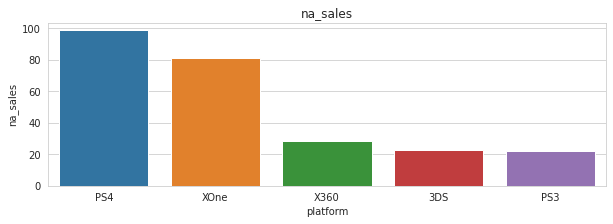

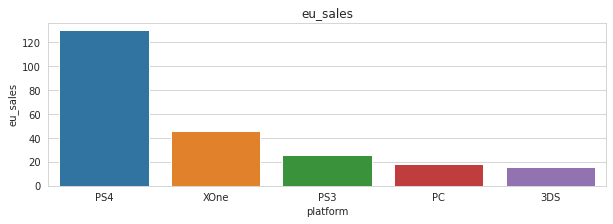

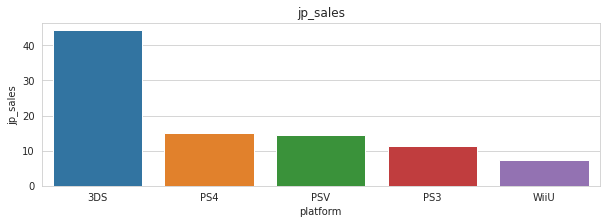

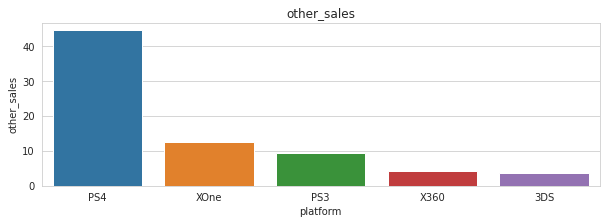

In [328]:
area = ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']
for a in area:
  platform_sales_area = current_data.pivot_table(index='platform', values=a, aggfunc='sum').sort_values(by=a, ascending=False).reset_index().head(5)
  plt.figure(figsize=(10, 3))
  sns.barplot(x='platform', y=a, data=platform_sales_area)
  plt.title(a)
  plt.show()

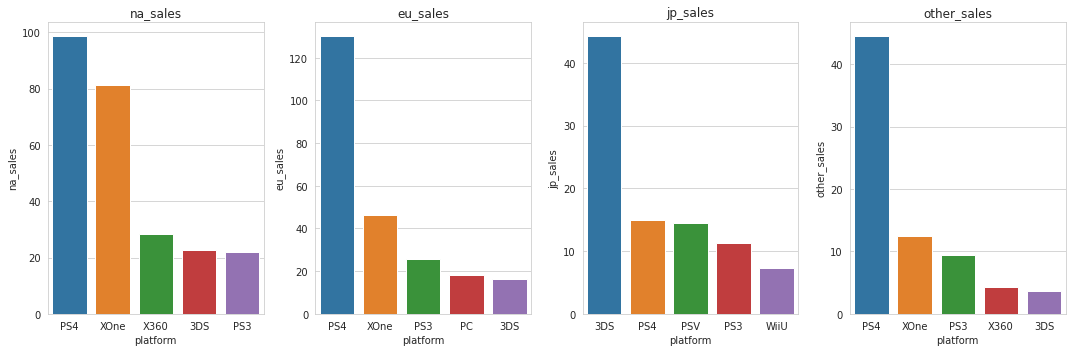

In [329]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
for i, a in enumerate(area):
    platform_sales_area = current_data.pivot_table(index='platform', values=a, aggfunc='sum').sort_values(by=a, ascending=False).reset_index().head(5)
    sns.barplot(x='platform', y=a, data=platform_sales_area, ax=axes[i])
    axes[i].set_title(a)
plt.tight_layout()
plt.show()

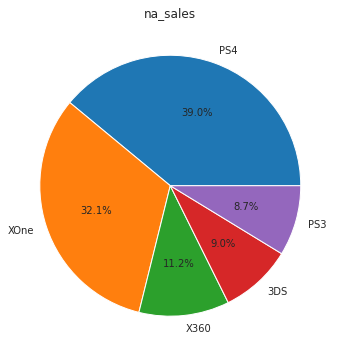

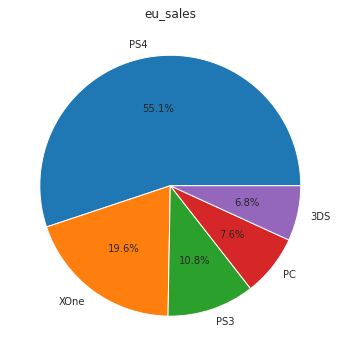

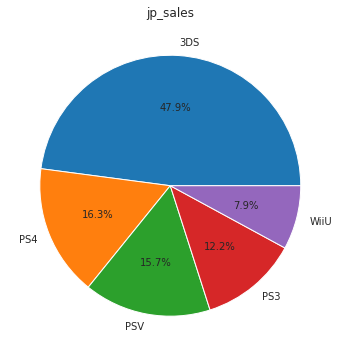

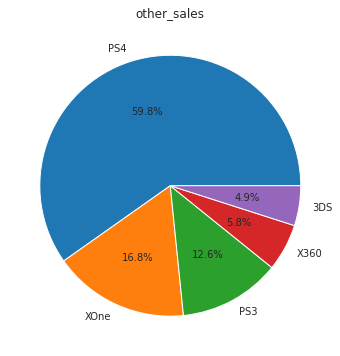

In [330]:
area = ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']
for a in area:
    
    platform_sales_area = current_data.pivot_table(index='platform', values=a, aggfunc='sum')\
        .sort_values(by=a, ascending=False).reset_index().head(5)
    
    plt.figure(figsize=(6, 6))
    plt.pie(platform_sales_area[a], labels=platform_sales_area['platform'], autopct='%1.1f%%')
    plt.title(a)
    plt.show()


Что же, PS4 популярна везде, она занимает значительюную долю по продажам игр в каждом регионе. Японцы как всегда в своем репертуаре.\
Теперь что по жанрам?

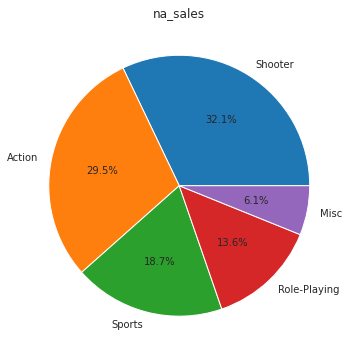

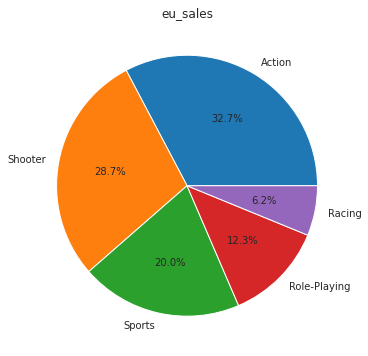

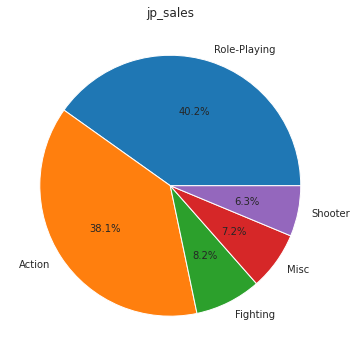

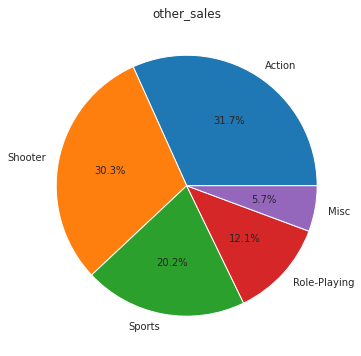

In [331]:
area = ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']
for a in area:
    
  genre_sales_area = current_data.pivot_table(index='genre', values=a, aggfunc='sum').sort_values(by=a, ascending=False).reset_index().head(5)
  
  plt.figure(figsize=(6, 6))
  plt.pie(genre_sales_area[a], labels=genre_sales_area['genre'], autopct='%1.1f%%')
  plt.title(a)
  plt.show()

Шутеры предпочитают американцы.\
Экшн выбор европейцев.\
Ну а японцы... любят отыгрывать роли.

Помимо любимых игр в разных регионах, можно сказать следующее: европейцы и северные американцы схожи в своих предпочтениях - топ 4 жанра одинаковые (шутеры, экшн, спортивные и ролевые игры), здесь близки доли, пусть и у американцев на первое место выбирается шутеры. Эти 4 жанра занимают подавляющую долю. Впрочем, это так и для остального мира (хотя данных по нему намного меньше, и что-то может измениться при наличии большего объема данных. Структуры же предпочтения Японцев отличается от остальных, это необходимо учитывать. Шутеры у них занимаю небольшую долю, спортивные игры не входят в топ 6, зато сюда попадают файтинги. Экшн же примерно также интересен Японцам как и ролевые игры.

**Посмотрим как рейтинг игры влияет на продажи в Северной Америке.**

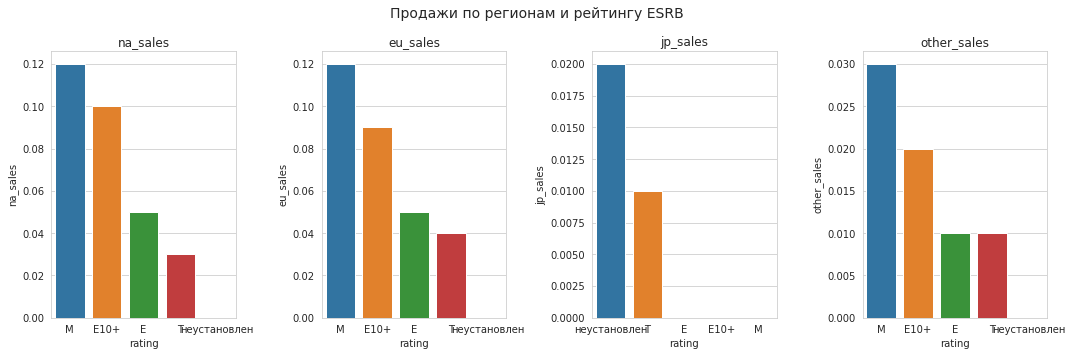

In [332]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
fig.suptitle('Продажи по регионам и рейтингу ESRB', fontsize=14)
for i, b in enumerate(area):
    esrb_sales_na = current_data.pivot_table(index='rating', values=b, aggfunc='median').sort_values(by=b, ascending=False).reset_index()
    sns.barplot(x='rating', y=b, data=esrb_sales_na, ax=axes[i])
    axes[i].set_title(b)
plt.tight_layout()
plt.show()

M - для людей старше 17лет. Впрочем не сильно отстает и более щадящий для психики E10+ - для всех старше 10 лет.

Это характерно для всех регионов кроме Японии. Могу предположить, что у них простно не действует данная классификация, либо они используют свою свобственную.

**Итак региональные особенности определенно вносят свой вклад в продажи, это необходимо учитывать. Также определенно есть рейтинги игр более предпочтительные для игроков.**

**Проверим пару гипотез**

**Первая гипотеза гласит, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые. Возьмем её за нулевую гипотезу, альтернативная в таком случае, что они отличаются.**

In [333]:
data_for_test = current_data.query('user_score != 1000')

In [334]:
alpha = 0.05 # критический уровень значимости.
               # Такой потому что я привык его видеть в медицинских исследованиях

In [335]:
print('Количество игр на XboxOne:', data_for_test.query('platform == "XOne"').shape[0])
print('Количество игр на PC:', data_for_test.query('platform == "PC"').shape[0])
print('Дисперсия для XboxOne:', data_for_test.query('platform == "XOne"')['user_score'].var())
print('Дисперсия для XboxOne:', data_for_test.query('platform == "PC"')['user_score'].var())

Количество игр на XboxOne: 165
Количество игр на PC: 122
Дисперсия для XboxOne: 1.8910066518847013
Дисперсия для XboxOne: 2.901154315133451


Разные по количеству выборки, разные дисперсии. equal_var примем за False. Тест Левеня проводить не буду, слишком явные различия.

In [336]:
platform_test = st.ttest_ind(current_data.query('platform == "XOne"')['user_score'],
                             current_data.query('platform == "PC"')['user_score'], equal_var=False)


print('\nЗначение p-value: ', platform_test.pvalue)

if platform_test.pvalue < alpha:
    print('\nОтвергаем нулевую гипотезу')
else:
    print('\nНе отвергаем нулевую гипотезу')


Значение p-value:  0.054353616253982724

Не отвергаем нулевую гипотезу


Не достаточно статистической значимости, что бы сказать что средние рейтинги действительно отличаются. Примем, что они одинаковые.

**Вторая гипотеза - Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.\
За нулевую гипотезу возьмем, что они все же одинаковые. Тогда альтернативная будет, что они разные**

In [337]:
genre_test = st.ttest_ind(current_data.query('genre == "Action"')['user_score'],
                             current_data.query('genre == "Sports"')['user_score'], equal_var=False)


print('\nЗначение p-value: ', genre_test.pvalue)

if genre_test.pvalue < alpha:
    print('\nОтвергаем нулевую гипотезу')
else:
    print('\nНе отвергаем нулевую гипотезу')


Значение p-value:  1.0200140830956413e-14

Отвергаем нулевую гипотезу


**Что же, достаточно убедительно можно сказать, что они действительно отличаются.**

**ВЫВОД:**

Был проведен анализ продаж игр на различных платформах в четырех регионах (Северная Америка, Европа, Япония и остальной мир). В результате обработки данных были удалены некорректные данные. В качестве временного диапазона для анализа были выбраны последние три года.\\
Ключевые платформы определены ка PS4 и XboxOne, это наиболее свежие платформы из популярных, стоит ожидать дальнейшую поддержку этих платформ разработчиками игр. PS4 популярна во всем мире, XboxOne широко используют в Америке, и она почти не распространена в Японии. Кроме того япония выделяется по жанровому предпочтению. Для этого региона более перспективным будет продажа ролевых и экшн игр, кроме того пусть и небольшую но существенную долю у них занимают файтинги. При выборе продаваемых игр можно смотреть на оценки критиков, но это не должно быть ключевым критерием. Кроме того, стоит учитывать возрастной рейтинг. Игры для взрослых и одобренные для всех старше 10 лет наиболее предпочтительны во всем мире. Однако, нужно учитывать, что судя по всему этого рейтинга не придерживаются в Японии. Особенно, учитывая их специфику предпочтения по жанрам, можно ожидать, что распределение по рейтингу там будет другое (если бы они придерживались данной классификации). Я бы рекомендовал более внимательно отнестись к специфики Японии, и подробнее и качественно собрать данные оттуда, учитывая приличные объемы продаж. Кроме того, было бы неплохо проанализировать изменения предпочтений по жанрам и платформам, для определения перспективных ниш.